<a href="https://colab.research.google.com/github/jeonghojo00/ImageClassification/blob/main/CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIFAR Object Recognition in Images

## Initial Setup

In [ ]:
pip install --upgrade torch torchvision

In [ ]:
# Data Import
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor

# General
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Pytorch libraries for models and input
import torch
import torchvision 
from torchvision import models
from torch import nn
from torch.utils.data import DataLoader
from torch.nn import functional as F
from torchvision.transforms import transforms

# Experiment
try:
  import optuna
except:
  !pip install optuna
  import optuna

# Save studied file
import joblib


     |████████████████████████████████| 308 kB 5.0 MB/s 
     |████████████████████████████████| 210 kB 62.5 MB/s 
     |████████████████████████████████| 81 kB 12.1 MB/s 
     |████████████████████████████████| 78 kB 8.1 MB/s 
     |████████████████████████████████| 49 kB 6.4 MB/s 
     |████████████████████████████████| 112 kB 50.0 MB/s 
     |████████████████████████████████| 146 kB 61.8 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=743fd3ce9cd035c8f0d17abbf4a5c8cf5b739f09b135a4db05df1819bbd4f4ac
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Change directory to the package folder
%cd '/content/drive/MyDrive/Colab Notebooks/DB'
# Verify the contents of the current folder
!ls

/content/drive/MyDrive/Colab Notebooks/DB
annotations			 dogs-vs-cats
cifar10				 enron_corpus
cifar10_128			 images
cifar10_224			 lightning_logs
cifar10_299			 mnist
cifar10_32			 model
cifar10_63			 resnet18_mnist_20220407.pt
cifar10_64			 study_20220407.pkl
cifar10_96			 study_cifar10_20220408.pkl
coco2017			 study_cifar10_latestModels_20220410.pkl
densenet161_cifar10_20220408.pt  study.pkl
dog.jpg				 train2017
dogs_vs_cats


## Explore CIFAR10 dataset

### Load CIFAR dataset from torchvision datasets

In [ ]:
train_ds = CIFAR10("cifar10", train=True, download=True, transform=ToTensor())
test_ds = CIFAR10("cifar10", train=False, download=True, transform=ToTensor())
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Dataset short review
print("Train_shape: ", train_ds.data.shape)
print("Train_label_shape: ", len(train_ds.targets))
print("Test_shape: ", test_ds.data.shape)

Train_shape:  (50000, 32, 32, 3)
Train_label_shape:  50000
Test_shape:  (10000, 32, 32, 3)


### Data Observations

In [ ]:
labels = train_ds.targets
labels = pd.DataFrame(data=list(labels), columns=['label'])
labels['value'] = 1
labels_counts = labels.groupby('label').sum()
labels_counts

,value
label,
0,5000
1,5000
2,5000
3,5000
4,5000
5,5000
6,5000
7,5000
8,5000


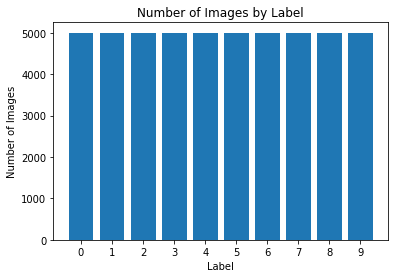

In [ ]:
plt.bar(labels_counts.index, labels_counts.value)
plt.xlabel("Label")
plt.ylabel("Number of Images")
plt.xticks(list(labels_counts.index))
plt.title("Number of Images by Label")
plt.show()

Train data is equally distributed among labels

### Show sample images

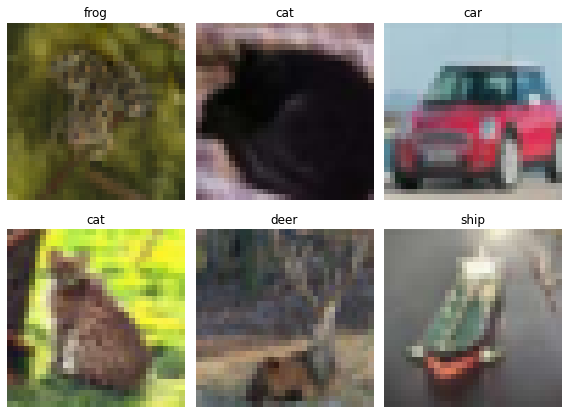

In [ ]:
# Show some randomly selected Train images and lables
import random

numImages = 6

random_index = np.random.choice(range(len(train_ds)), numImages)

plt.figure(figsize=(8,6))
plt.title("Some Random Training Images")
for i in range(numImages):
    idx = random_index[i]
    plt.subplot(2,3,i+1)
    plt.imshow(train_ds.data[idx])
    plt.axis("off")
    plt.title(classes[train_ds.targets[idx]])
plt.tight_layout()
plt.show() 

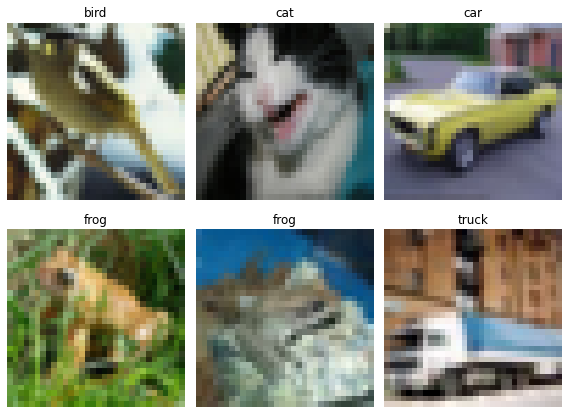

In [ ]:
# Show some randomly selected Test images and lables
random_index = np.random.choice(range(len(test_ds)), numImages)

plt.figure(figsize=(8,6))
plt.title("Some Random Testing Images")
for i in range(numImages):
    idx = random_index[i]
    plt.subplot(2,3,i+1)
    plt.imshow(test_ds.data[idx],cmap=plt.get_cmap("gray"))
    plt.axis("off")
    plt.title(classes[test_ds.targets[idx]])
plt.tight_layout()
plt.show() 

Now, we see that train and test datasets have the same shapes and format that we can work in the same way

## Experiment and Find the best model and hyperparameters

In [ ]:
EPOCHS = 20
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
from torchvision.transforms import transforms
from torch.utils.data import random_split

def get_cifar10(param_name, batch_size):

    img_size_dict = {
        "resnet18": 32,
        "inception_v3": 299,
        "densenet161": 96,
        "alexnet": 63,
        "mobilenet_v3_large": 32,
        "vgg16": 32,
        "mnasnet1_0": 96,
        "efficientnet_b5": 96,
        "convnext_base": 96,
        "vit_b_16": 224,
        "regnet_y_8gf": 96}

    '''
        "resnet18": 32,
        "inception_v3": 299,
        "densenet161": 32,
        "alexnet": 63,
        "mobilenet_v3_large": 32,
        "vgg16": 32,
        "mnasnet1_0": 96,
        "efficientnet_b5": 64,
        "convnext_base": 64,
        "vit_b_16": 224,
        "regnet_y_8gf": 64}

        Replace regular input size of each model with minimum possible input size for each model 
        to reduce number of hyperparameters and to reduce memory usages.

        ** Regular input size of each model
        "resnet18": 224,
        "inception_v3": 299,
        "densenet161": 224,
        "alexnet": 227,
        "mobilenet_v3_small": 224,
        "vgg16": 224,
        "mnasnet1_0": 224,
        "efficientnet_b5": 456, 
        "convnext_base": 224 ,
        "vit_b_16": 224, 
        "regnet_y_8gf": 224
    '''

    img_size = img_size_dict[param_name]

    transform=transforms.Compose([
                                  transforms.Resize(img_size),
                                  transforms.ToTensor(),
    ])

    # Get Dataset
    train_dataset = CIFAR10("cifar10_"+str(img_size), train=True, download=True, transform=transform)
    test_ds = CIFAR10("cifar10_"+str(img_size), train=False, download=True, transform=transform)

    torch.manual_seed(43)
    val_size = int(len(train_dataset) * 0.2)
    train_size = len(train_dataset) - val_size

    train_ds, val_ds = random_split(train_dataset, [train_size, val_size])

    test_size = len(test_ds)

    # One batch includes 64 images and labels
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=True)
    test_dl = DataLoader(test_ds, batch_size=batch_size)

    return train_dl, val_dl, test_dl, train_size, val_size, test_size

In [ ]:
# Check if torchvision's version is 0.12 to prevent further disrutpion in training.
model = models.convnext_base(pretrained=False, num_classes=10)
model = models.vit_b_16(pretrained=False, num_classes=10)

In [ ]:
def get_model(model_name: str = "resnet18"):
    if model_name == "resnet18":
        model = models.resnet18(pretrained=False, num_classes=10)
    elif model_name == "inception_v3":
        model = models.inception_v3(pretrained=False, num_classes=10)
    elif model_name == "densenet161":
        model = models.densenet161(pretrained=False, num_classes=10)
    elif model_name == "alexnet":
        model = models.alexnet(pretrained=False, num_classes=10)
    elif model_name == "mobilenet_v3_large":
        model = models.mobilenet_v3_large(pretrained=False, num_classes=10)
    elif model_name == "vgg16":
        model = models.vgg16(pretrained=False, num_classes=10)
    elif model_name == "mnasnet1_0":
        model = models.mnasnet1_0(pretrained=False, num_classes=10)
    elif model_name == "efficientnet_b5":
        model = models.efficientnet_b5(pretrained=False, num_classes=10)
    elif model_name == "convnext_base":
        model = models.convnext_base(pretrained=False, num_classes=10)
    elif model_name == "vit_b_16":
        model = models.vit_b_16(pretrained=False, num_classes=10)
    elif model_name == "regnet_y_8gf":
        model = models.regnet_y_8gf(pretrained=False, num_classes=10)
    return model

    

In [ ]:
# Train and evaluate the accuarcy of neural network model
def train_and_evaluate(params, model, trial):

    train_dataloader, val_dataloader, train_len, val_len = get_cifar10(params["model_name"], 32)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    # Configure optimizer
    optimizer = getattr(torch.optim, params["optimizer_name"])(model.parameters(), lr=params["learning_rate"])

    if use_cuda:
        model = model.cuda()
        criterion = criterion.cuda()

    for epoch_num in range(EPOCHS):

        total_acc_train = 0
        total_loss_train = 0

        for train_input, train_label in train_dataloader:

            train_label = train_label.to(device)
            train_input = train_input.to(device)

            #output = model(train_input.float())
            output = model(train_input)
            if params["model_name"] == "inception_v3":
                output = output.logits
                
            #batch_loss = criterion(output, train_label.long())
            batch_loss = criterion(output, train_label)
            total_loss_train += batch_loss.item()
                
            acc = (output.argmax(dim=1) == train_label).sum().item()
            total_acc_train += acc

            model.zero_grad()
            batch_loss.backward()
            optimizer.step()

            
        total_acc_val = 0
        total_loss_val = 0

        with torch.no_grad():

            for val_input, val_label in val_dataloader:

                val_label = val_label.to(device)
                val_input = val_input.to(device)

                #output = model(val_input.float())
                output = model(val_input)
                if params["model_name"] == "inception_v3":
                    output = output.logits

                #batch_loss = criterion(output, val_label.long())
                batch_loss = criterion(output, val_label)
                total_loss_val += batch_loss.item()
                    
                acc = (output.argmax(dim=1) == val_label).sum().item()
                total_acc_val += acc
            
        accuracy = total_acc_val/val_len
            
        # Add prune mechanism
        trial.report(accuracy, epoch_num)

        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return accuracy

### 1. 7 Historical Models comparison

In [ ]:
# Define a set of hyperparameter values, build the model, train the model, and evaluate the accuracy 
def objective(trial):

    params = {
              'model_name': trial.suggest_categorical('model_name',["resnet18", "inception_v3", "densenet161", "alexnet", "mobilenet_v3_large", "vgg16", "mnasnet1_0"]),
              'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
              'optimizer_name': trial.suggest_categorical("optimizer_name", ["Adam", "RMSprop", "SGD"]),
              }
    
    # Get a model
    model = get_model(params["model_name"])
    
    accuracy = train_and_evaluate(params, model, trial)

    return accuracy

In [ ]:
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=20)

[I 2022-04-08 17:29:13,850] A new study created in memory with name: no-name-83b341ae-536c-48b1-8f7e-961824433ea5


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting cifar10_32/cifar-10-python.tar.gz to cifar10_32
Files already downloaded and verified


[I 2022-04-08 17:49:40,924] Trial 0 finished with value: 0.7379 and parameters: {'model_name': 'densenet161', 'learning_rate': 0.02569176020916609, 'optimizer_name': 'Adam', 'batch_size': 64}. Best is trial 0 with value: 0.7379.


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting cifar10_96/cifar-10-python.tar.gz to cifar10_96
Files already downloaded and verified


[I 2022-04-08 18:00:00,527] Trial 1 finished with value: 0.7538 and parameters: {'model_name': 'mnasnet1_0', 'learning_rate': 0.00692067778281595, 'optimizer_name': 'Adam', 'batch_size': 64}. Best is trial 1 with value: 0.7538.


Files already downloaded and verified
Files already downloaded and verified


[I 2022-04-08 18:05:37,276] Trial 2 finished with value: 0.5103 and parameters: {'model_name': 'mobilenet_v3_large', 'learning_rate': 0.00015172157891158513, 'optimizer_name': 'RMSprop', 'batch_size': 64}. Best is trial 1 with value: 0.7538.


Files already downloaded and verified
Files already downloaded and verified


[I 2022-04-08 18:13:30,846] Trial 3 finished with value: 0.6592 and parameters: {'model_name': 'mnasnet1_0', 'learning_rate': 0.0019641127010900585, 'optimizer_name': 'RMSprop', 'batch_size': 64}. Best is trial 1 with value: 0.7538.


Files already downloaded and verified
Files already downloaded and verified


[I 2022-04-08 18:18:19,695] Trial 4 finished with value: 0.5946 and parameters: {'model_name': 'resnet18', 'learning_rate': 0.0023689815976951733, 'optimizer_name': 'SGD', 'batch_size': 64}. Best is trial 1 with value: 0.7538.


Files already downloaded and verified
Files already downloaded and verified


[I 2022-04-08 18:19:16,041] Trial 5 pruned. 
/usr/local/lib/python3.7/dist-packages/torchvision/models/inception.py:83: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  ' due to scipy/scipy#11299), please set init_weights=True.', FutureWarning)


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting cifar10_299/cifar-10-python.tar.gz to cifar10_299
Files already downloaded and verified


[I 2022-04-08 18:33:05,287] Trial 6 pruned. 


Files already downloaded and verified
Files already downloaded and verified


[I 2022-04-08 18:34:28,507] Trial 7 pruned. 


Files already downloaded and verified
Files already downloaded and verified


[I 2022-04-08 18:54:25,642] Trial 8 finished with value: 0.7665 and parameters: {'model_name': 'densenet161', 'learning_rate': 0.00047449414597460084, 'optimizer_name': 'Adam', 'batch_size': 64}. Best is trial 8 with value: 0.7665.


Files already downloaded and verified
Files already downloaded and verified


[I 2022-04-08 18:59:14,300] Trial 9 pruned. 


Files already downloaded and verified
Files already downloaded and verified


[I 2022-04-08 19:19:08,522] Trial 10 finished with value: 0.707 and parameters: {'model_name': 'densenet161', 'learning_rate': 0.00020408929402796017, 'optimizer_name': 'Adam', 'batch_size': 64}. Best is trial 8 with value: 0.7665.


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting cifar10_63/cifar-10-python.tar.gz to cifar10_63
Files already downloaded and verified


[I 2022-04-08 19:19:57,444] Trial 11 pruned. 


Files already downloaded and verified
Files already downloaded and verified


[I 2022-04-08 19:20:59,641] Trial 12 pruned. 


Files already downloaded and verified
Files already downloaded and verified


[I 2022-04-08 19:24:02,142] Trial 13 pruned. 


Files already downloaded and verified
Files already downloaded and verified


[I 2022-04-08 19:26:06,130] Trial 14 pruned. 
/usr/local/lib/python3.7/dist-packages/torchvision/models/inception.py:83: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  ' due to scipy/scipy#11299), please set init_weights=True.', FutureWarning)


Files already downloaded and verified
Files already downloaded and verified


[I 2022-04-08 19:39:49,063] Trial 15 pruned. 


Files already downloaded and verified
Files already downloaded and verified


[I 2022-04-08 19:40:21,418] Trial 16 pruned. 


Files already downloaded and verified
Files already downloaded and verified


[I 2022-04-08 19:41:01,068] Trial 17 pruned. 


Files already downloaded and verified
Files already downloaded and verified


[I 2022-04-08 19:41:49,714] Trial 18 pruned. 


Files already downloaded and verified
Files already downloaded and verified


[I 2022-04-08 20:00:04,136] Trial 19 finished with value: 0.7341 and parameters: {'model_name': 'densenet161', 'learning_rate': 0.00039705328989624814, 'optimizer_name': 'RMSprop', 'batch_size': 64}. Best is trial 8 with value: 0.7665.


In [ ]:
best_trial = study.best_trial
print("Best Trial with Parameters")
for key, value in best_trial.params.items():
    print("  {}: {}".format(key, value))

Best Trial with Parameters
  model_name: densenet161
  learning_rate: 0.00047449414597460084
  optimizer_name: Adam
  batch_size: 64


In [ ]:
fig = optuna.visualization.plot_intermediate_values(study)
fig.show()

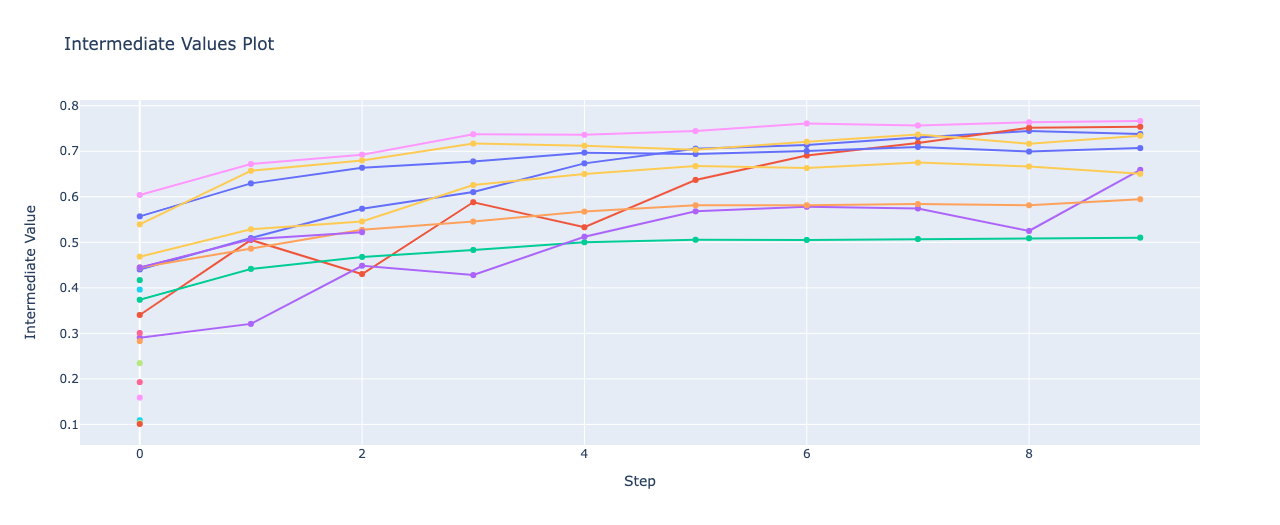

In [ ]:
fig = optuna.visualization.plot_optimization_history(study)
fig.show()

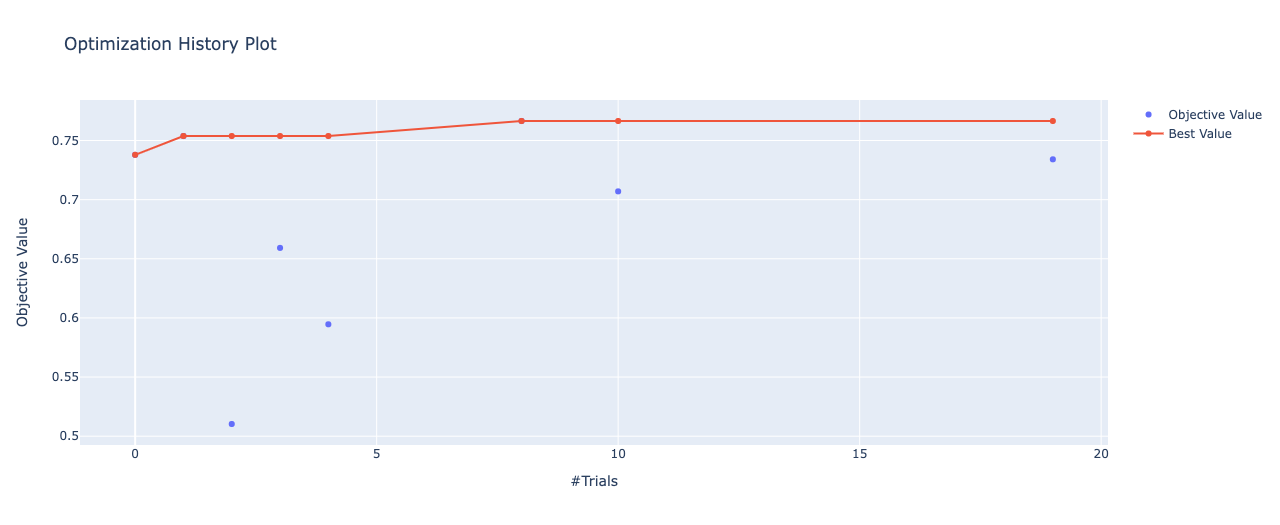

In [ ]:
fig = optuna.visualization.plot_parallel_coordinate(study)
fig.show()

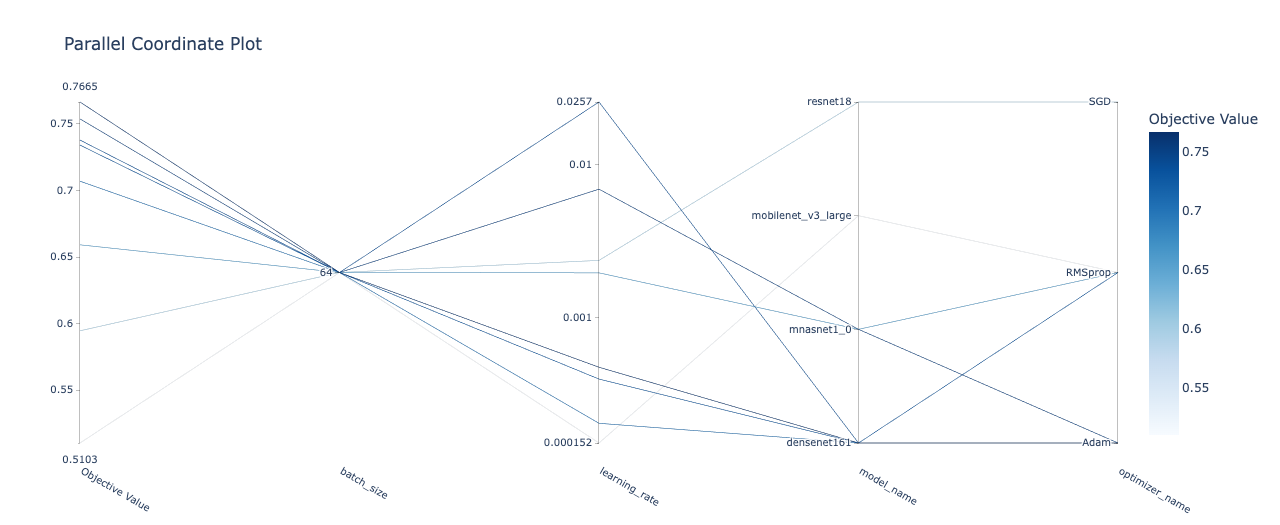

In [ ]:
fig = optuna.visualization.plot_param_importances(study)
fig.show()

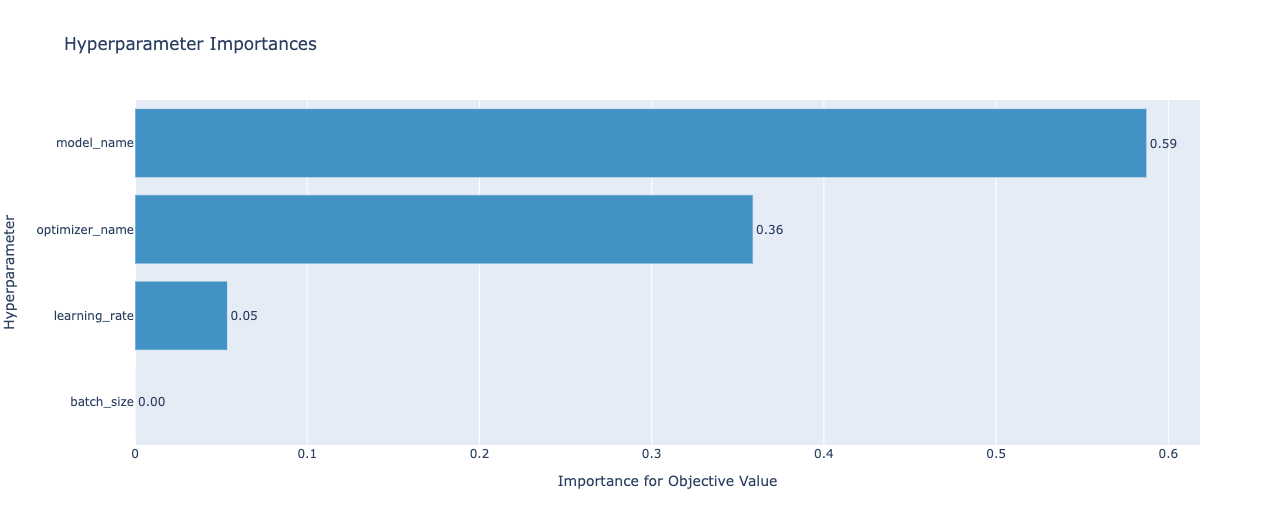

In [ ]:
fig = optuna.visualization.plot_slice(study)
fig.show()

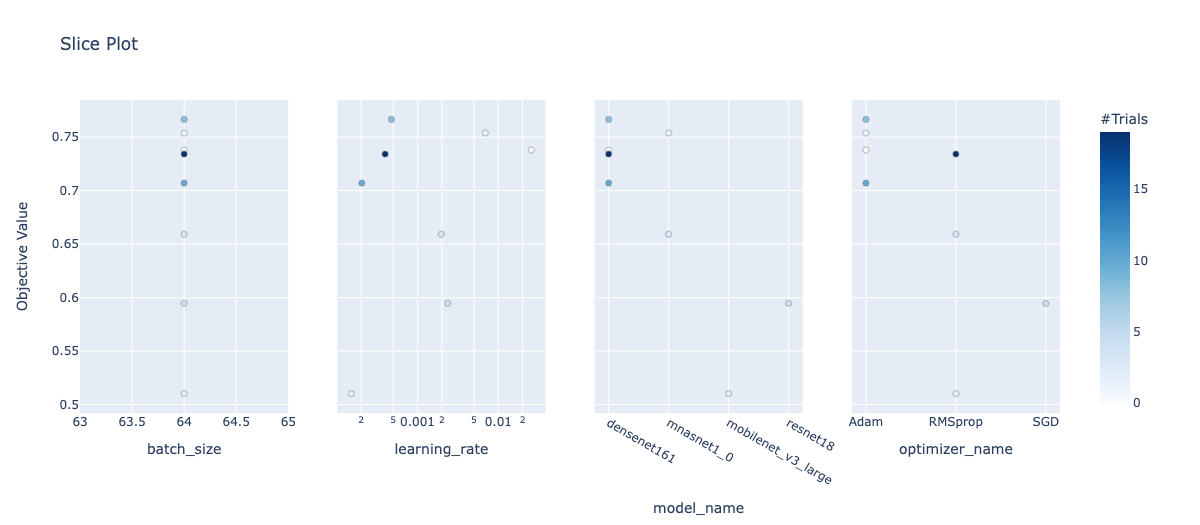

In [ ]:
joblib.dump(study, "study_cifar10_20220408.pkl")

['study_cifar10_20220408.pkl']

In [ ]:
loaded_study = joblib.load("study_cifar10_20220407.pkl")
print("Best trial until now:")
print(" Value: ", loaded_study.best_trial.value)
print(" Params: ")
for key, value in loaded_study.best_trial.params.items():
    print(f"    {key}: {value}")

### 2. Latest models comparison

#### Study

In [ ]:
# Define a set of hyperparameter values, build the model, train the model, and evaluate the accuracy 
def objective(trial):

    params = {
              'model_name': trial.suggest_categorical('model_name',["efficientnet_b5", "densenet161", "convnext_base", "vit_b_16", "mnasnet1_0", "regnet_y_8gf"]),
              'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
              'optimizer_name': trial.suggest_categorical("optimizer_name", ["Adam", "RMSprop", "SGD"]),
              }
    
    # Get a model
    model = get_model(params["model_name"])
    
    accuracy = train_and_evaluate(params, model, trial)

    return accuracy

In [ ]:
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=30)

[I 2022-04-30 20:03:28,024] A new study created in memory with name: no-name-595494cb-7205-4223-91ab-f8d5428048ed


Files already downloaded and verified
Files already downloaded and verified


[I 2022-04-30 21:41:47,477] Trial 0 finished with value: 0.1 and parameters: {'model_name': 'convnext_base', 'learning_rate': 0.0036542194600841867, 'optimizer_name': 'SGD'}. Best is trial 0 with value: 0.1.


Files already downloaded and verified
Files already downloaded and verified


[I 2022-04-30 23:51:28,553] Trial 1 finished with value: 0.6522 and parameters: {'model_name': 'regnet_y_8gf', 'learning_rate': 0.0020295406621810186, 'optimizer_name': 'SGD'}. Best is trial 1 with value: 0.6522.


Files already downloaded and verified
Files already downloaded and verified


[I 2022-05-01 05:18:59,125] Trial 2 finished with value: 0.1455 and parameters: {'model_name': 'vit_b_16', 'learning_rate': 0.025940695784113878, 'optimizer_name': 'Adam'}. Best is trial 1 with value: 0.6522.


Files already downloaded and verified
Files already downloaded and verified


[I 2022-05-01 10:30:28,046] Trial 3 finished with value: 0.1683 and parameters: {'model_name': 'vit_b_16', 'learning_rate': 0.02269763332660878, 'optimizer_name': 'RMSprop'}. Best is trial 1 with value: 0.6522.


Files already downloaded and verified
Files already downloaded and verified


KeyboardInterrupt: ignored

#### Result

In [ ]:
best_trial = study.best_trial
print("Best Trial with Parameters")
for key, value in best_trial.params.items():
    print("  {}: {}".format(key, value))

##### Figures

In [ ]:
fig = optuna.visualization.plot_intermediate_values(study)
fig.show()

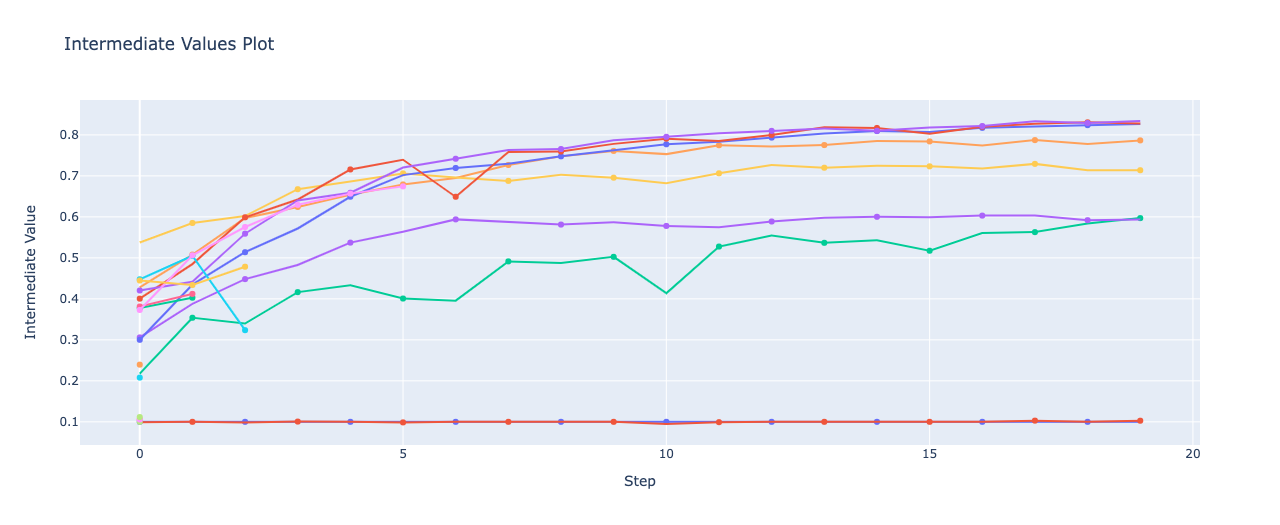

In [ ]:
fig = optuna.visualization.plot_optimization_history(study)
fig.show()

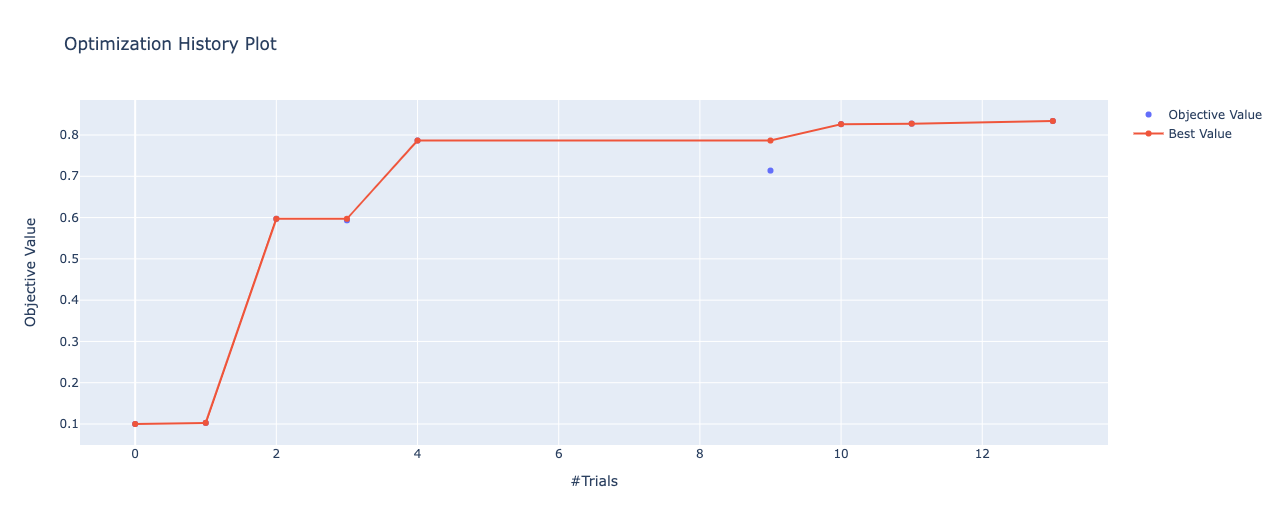

In [ ]:
fig = optuna.visualization.plot_parallel_coordinate(study)
fig.show()

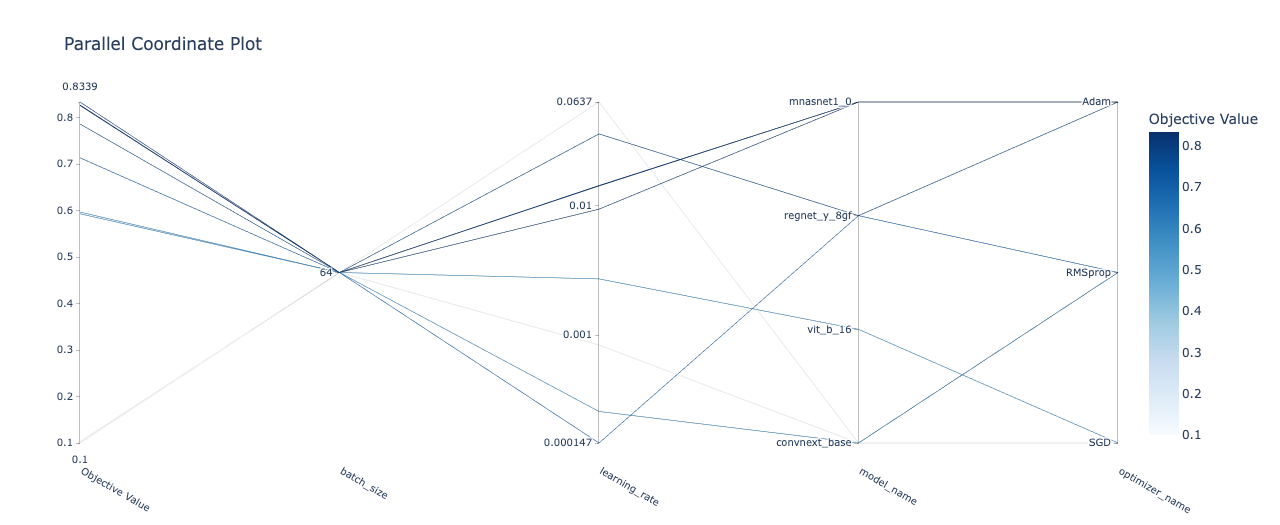

In [ ]:
fig = optuna.visualization.plot_param_importances(study)
fig.show()

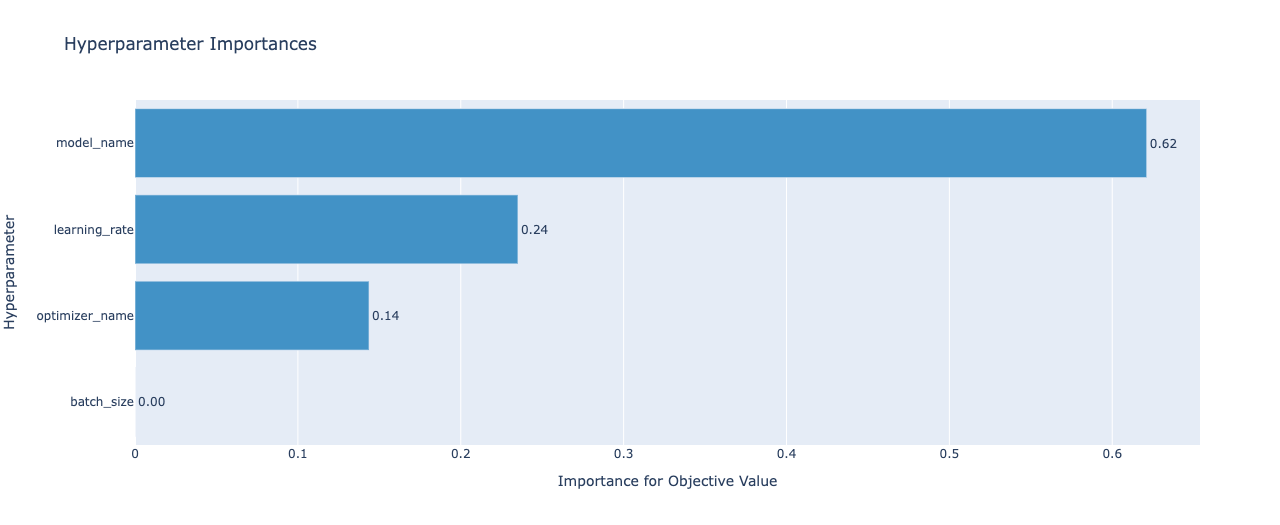

In [ ]:
fig = optuna.visualization.plot_slice(study)
fig.show()

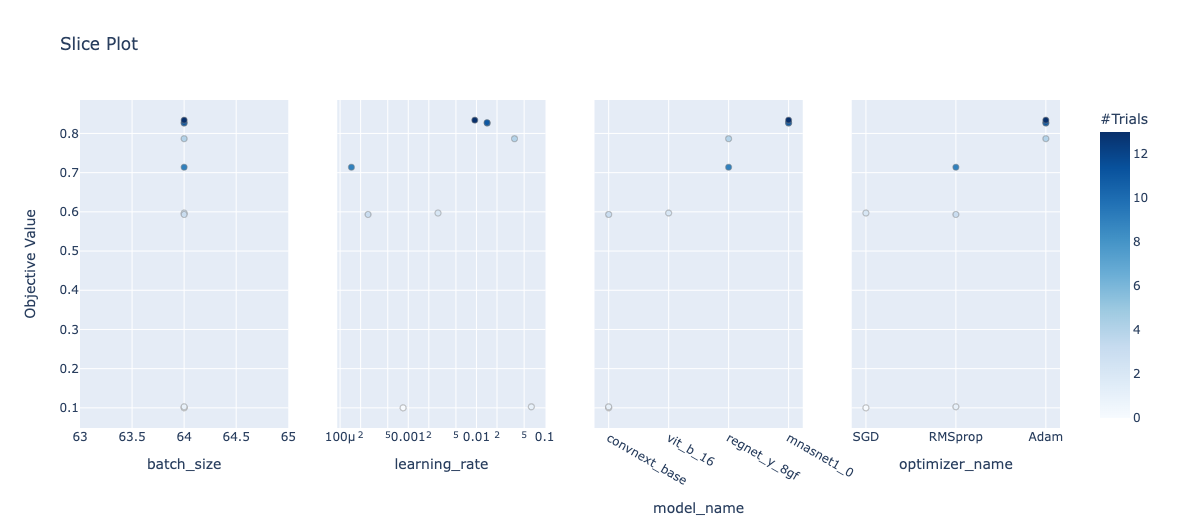

#### Save

In [ ]:
joblib.dump(study, "study_cifar10_latestModels_20220430.pkl")

## Train CIFAR10 in accordance with the results of the above study

* Best Trial with Parameters
  - model_name: mnasnet1_0 </br>
  - learning_rate: 0.009447902445516574 </br>
  - optimizer_name: Adam </br>
  - batch_size: 64

### Define Train and Test functions

In [ ]:
AVAIL_GPUS = min(1, torch.cuda.device_count())
LR = 0.01
EPOCHS = 30
BATCH_SIZE = 64
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using {}".format(DEVICE))

Using cuda:0


In [ ]:
import time
import copy
import pickle

def train_model(model, model_name, model_save_path, result_save_path, criterion, optimizer, scheduler, num_epochs=1):
    print("Training...")

    train_dl, val_dl, test_dl, train_size, val_size, test_size = get_cifar10(model_name, BATCH_SIZE)

    since = time.time()

    best_model_state = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    res = {}
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        epoch_loss = 0.0
        epoch_acc = 0.0
        epoch_correct = 0
        
        for idx, (img, label) in enumerate(train_dl):
            img = img.to(DEVICE)
            label = label.to(DEVICE)
            
            # Forward
            output = model(img)
            loss = criterion(output, label)
            acc = (output.argmax(dim=1) == label).sum().item()
            
            # Backward
            optimizer.zero_grad()
            loss.backward()
            
            # Gradient Descent or Adam step
            optimizer.step()
            
            epoch_loss += (loss.item()/train_size)
            epoch_acc += (acc/train_size)
            
        print(f'Train Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')
        res[epoch+1] = {"Train_Loss": epoch_loss, 
                        "Train_Acc": epoch_acc}
        scheduler.step()

        with torch.no_grad():
            epoch_val_acc = 0.0
            epoch_val_loss = 0.0
            epoch_val_correct = 0
            
            for img, label in val_dl:
                img = img.to(DEVICE)
                label = label.to(DEVICE)
                
                val_output = model(img)
                val_loss = criterion(val_output, label)
                val_acc = (val_output.argmax(dim=1) == label).sum().item()
                
                epoch_val_acc += (val_acc/val_size)
                epoch_val_loss += (val_loss.item()/val_size)
                
            print(f'Validation Loss: {epoch_val_loss:.4f}, Accuracy: {epoch_val_acc:.4f}')
            res[epoch+1] = {"Val_Loss": epoch_val_loss, 
                            "Val_Acc": epoch_val_acc}
        
            if epoch_val_acc > best_acc:
                best_acc = epoch_val_acc
                best_model_state = copy.deepcopy(model.state_dict())
                if not os.path.isdir("model"):
                    os.mkdir("model")
                torch.save(model.state_dict(), model_save_path)
                print("Model Saved")
    
    # When Training is completed
    time_elapsed = time.time() - since
    print(f'Train completed in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s')
    print(f'Best Val Accuracy: {best_acc:.4f}')

    # Save result in pickle
    with open(result_save_path, 'wb') as f:
        pickle.dump(res, f)
    
    # Return the model with weights of the best accuracy
    model.load_state_dict(best_model_state)
    return model, test_dl, test_size


In [ ]:
def test_model(model, model_path, test_dl, test_size):
    print("Testing...")
    since = time.time()  
    total_correct = 0

    # Load Model
    model.load_state_dict(torch.load(model_path))

    with torch.no_grad():
        for img, label in test_dl:
            img = img.to(DEVICE)
            label = label.to(DEVICE)
            output = model(img)

            acc = (output.argmax(dim=1) == label).sum().item()
            total_correct += acc

    # When Testing is completed
    time_elapsed = time.time() - since
    print(f'Test completed in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s')
    print(f'Test Accuracy: {total_correct/test_size:.4f}')


### Train with a chosen model

In [ ]:
model_name = "mnasnet1_0"

# Load a model
model = models.mnasnet1_0(pretrained=False)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Sequential(nn.Linear(num_ftrs, 10))
model.to(DEVICE)

# Define an optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# Scheduler: Update learning rate: Every 5 epochs update Learning rate by multiply by 0.1
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Define a loss function
criterion = nn.CrossEntropyLoss()

# Define a path to save the trained model
model_save_path = './model/cifar10'+model_name+'.pt'
result_save_path = './result/cifar10'+model_name+'.pkl'

In [ ]:
# Train
model, test_dl, test_size = train_model(model, model_name, model_save_path, result_save_path, criterion, optimizer, scheduler, num_epochs=EPOCHS)

Training...
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/30
----------
Train Loss: 0.0292, Accuracy: 0.2792
Validation Loss: 0.0258, Accuracy: 0.3312
Model Saved
Epoch 2/30
----------
Train Loss: 0.0221, Accuracy: 0.4720
Validation Loss: 0.0193, Accuracy: 0.5595
Model Saved
Epoch 3/30
----------
Train Loss: 0.0173, Accuracy: 0.6031
Validation Loss: 0.0165, Accuracy: 0.6333
Model Saved
Epoch 4/30
----------
Train Loss: 0.0147, Accuracy: 0.6684
Validation Loss: 0.0142, Accuracy: 0.6876
Model Saved
Epoch 5/30
----------
Train Loss: 0.0130, Accuracy: 0.7107
Validation Loss: 0.0134, Accuracy: 0.7022
Model Saved
Epoch 6/30
----------
Train Loss: 0.0117, Accuracy: 0.7417
Validation Loss: 0.0117, Accuracy: 0.7482
Model Saved
Epoch 7/30
----------
Train Loss: 0.0106, Accuracy: 0.7670
Validation Loss: 0.0118, Accuracy: 0.7488
Model Saved
Epoch 8/30
----------
Train Loss: 0.0073, Accuracy: 0.8416
Validation Loss: 0.0095, Accuracy: 0.7991
Model Saved
Epoch 9/

In [ ]:
test_model(model, model_save_path, test_dl, test_size)

Testing...
Test completed in 0m 5s
Test Accuracy: 0.8106


### Train with a chosen model with Transfer Learning

In [ ]:
model_name = "mnasnet1_0"

# Load a model
model = models.mnasnet1_0(pretrained=True)
## Freeze weights of the loaded pretrained model
for param in model.parameters():
    param.requires_grad = False
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Sequential(nn.Linear(num_ftrs, 10))
model.to(DEVICE)

# Define an optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# Scheduler: Update learning rate: Every 5 epochs update Learning rate by multiply by 0.1
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Define a loss function
criterion = nn.CrossEntropyLoss()

# Define a path to save the trained model
model_save_path = './model/cifar10'+model_name+'TL.pt'
result_save_path = './result/cifar10'+model_name+'TL.pkl'

In [ ]:
# Train
model, test_dl, test_size = train_model(model, model_name, model_save_path, result_save_path, criterion, optimizer, scheduler, num_epochs=EPOCHS)

Training...
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/30
----------
Train Loss: 0.0023, Accuracy: 0.9504
Validation Loss: 0.0107, Accuracy: 0.8133
Model Saved
Epoch 2/30
----------
Train Loss: 0.0023, Accuracy: 0.9525
Validation Loss: 0.0106, Accuracy: 0.8145
Model Saved
Epoch 3/30
----------
Train Loss: 0.0023, Accuracy: 0.9521
Validation Loss: 0.0106, Accuracy: 0.8115
Epoch 4/30
----------
Train Loss: 0.0024, Accuracy: 0.9512
Validation Loss: 0.0106, Accuracy: 0.8141
Epoch 5/30
----------
Train Loss: 0.0023, Accuracy: 0.9519
Validation Loss: 0.0105, Accuracy: 0.8174
Model Saved
Epoch 6/30
----------
Train Loss: 0.0023, Accuracy: 0.9514
Validation Loss: 0.0108, Accuracy: 0.8143
Epoch 7/30
----------
Train Loss: 0.0022, Accuracy: 0.9522
Validation Loss: 0.0105, Accuracy: 0.8125
Epoch 8/30
----------
Train Loss: 0.0023, Accuracy: 0.9525
Validation Loss: 0.0108, Accuracy: 0.8104
Epoch 9/30
----------
Train Loss: 0.0023, Accuracy: 0.9527
Validatio

In [ ]:
test_model(model, model_save_path, test_dl, test_size)

Testing...
Test completed in 0m 5s
Test Accuracy: 0.8097


## Evaluated the Trained Model

In [ ]:
def get_prediction(x, model: nn.Module):
    with torch.no_grad():
        probabilities = torch.softmax(model(x), dim=1)
        predicted_class = torch.argmax(probabilities, dim=1)
    return predicted_class, probabilities

In [ ]:
from tqdm.autonotebook import tqdm

In [ ]:
# model_save_path = "./model/cifar10_mnasnet1_0.pt"
inference_model = mnasnet1_0Cifar10().to(DEVICE)
inference_model.load_state_dict(torch.load(model_save_path))

<All keys matched successfully>

In [ ]:
inference_model

In [ ]:
true_y, pred_y = [], []
for batch in tqdm(iter(test_dl), total=len(test_dl)):
    x, y = batch
    x = x.to(DEVICE)

    true_y.extend(y)
    preds, probs = get_prediction(x, inference_model)
    pred_y.extend(preds.cpu())

  0%|          | 0/157 [00:00<?, ?it/s]

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(true_y, pred_y, digits=3))

              precision    recall  f1-score   support

           0      0.830     0.847     0.839      1000
           1      0.950     0.880     0.914      1000
           2      0.814     0.754     0.783      1000
           3      0.685     0.688     0.687      1000
           4      0.792     0.841     0.816      1000
           5      0.734     0.810     0.770      1000
           6      0.889     0.882     0.886      1000
           7      0.919     0.829     0.872      1000
           8      0.905     0.905     0.905      1000
           9      0.871     0.927     0.898      1000

    accuracy                          0.836     10000
   macro avg      0.839     0.836     0.837     10000
weighted avg      0.839     0.836     0.837     10000



## Inferences

In [ ]:
test_imgs, test_labels = next(iter(test_dl))
test_imgs = test_imgs.to(DEVICE)

print("Number of samples in the current batch: ", len(test_labels))

Number of samples in the current batch:  64


In [ ]:
test_imgs.shape

torch.Size([64, 3, 96, 96])

In [ ]:
preds, probs = get_prediction(test_imgs, inference_model)

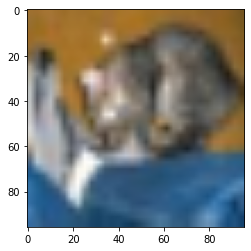

Predicted Label: 3 (cat)
True Label:      3 (cat)




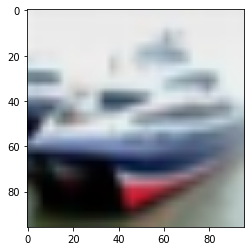

Predicted Label: 8 (ship)
True Label:      8 (ship)




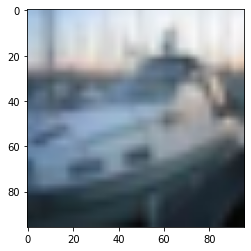

Predicted Label: 1 (car)
True Label:      8 (ship)




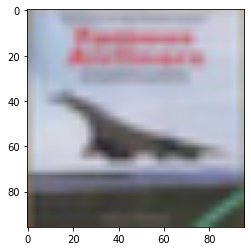

Predicted Label: 0 (plane)
True Label:      0 (plane)




In [ ]:
for i in range(4):
    a_img = test_imgs[i].squeeze()
    a_label = test_labels[i]
    
    # Current a_img shape is (3, 96, 96) = (channel, height, width). We need to convert it to (height, width, channel) to display the image
    a_img = np.transpose(a_img.cpu(), (1, 2, 0))
    plt.imshow(a_img)
    plt.show()

    print("Predicted Label: {} ({})".format(preds[i].item(), classes[preds[i].item()]))
    print("True Label:      {} ({})".format(a_label.item(), classes[a_label.item()]))
    print("")
    print("")

### Checking if the current data can be visualated with plt.imhow()

In [ ]:
def valid_imshow_data(data):
    data = np.asarray(data)
    if data.ndim == 2:
        return True
    elif data.ndim == 3:
        if 3 <= data.shape[2] <= 4:
            return True
        else:
            print('The "data" has 3 dimensions but the last dimension '
                  'must have a length of 3 (RGB) or 4 (RGBA), not "{}".'
                  ''.format(data.shape[2]))
            return False
    else:
        print('To visualize an image the data must be 2 dimensional or '
              '3 dimensional, not "{}".'
              ''.format(data.ndim))
        return False

In [ ]:
a_img = test_imgs[0]
valid_imshow_data(np.asarray(a_img.cpu()))

The "data" has 3 dimensions but the last dimension must have a length of 3 (RGB) or 4 (RGBA), not "96".


False

In [ ]:
np.transpose(a_img.cpu(), (1, 2, 0)).shape

torch.Size([96, 96, 3])